In [140]:
import heapq

class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')


In [141]:
# M/D/1 queue

import scipy.stats as sts


class Queue:
    def __init__(self, service_rate):
        # Store the deterministic service time for an M/D/1 queue
        self.service_time = 1 / service_rate
        # We start with an empty queue and the server not busy
        self.people_in_queue = 0
        self.people_being_served = 0

    def add_customer(self, schedule):
        # Add the customer to the queue
        self.people_in_queue += 1
        if self.people_being_served < 1:
            # This customer can be served immediately
            schedule.add_event_after(0, self.start_serving_customer)
            
    def start_serving_customer(self, schedule):
        # Move the customer from the queue to a server
        self.people_in_queue -= 1
        self.people_being_served += 1
        # Schedule when the server will be done with the customer
        schedule.add_event_after(
            self.service_time,
            self.finish_serving_customer)
            
    def finish_serving_customer(self, schedule):
        # Remove the customer from the server
        self.people_being_served -= 1
        if self.people_in_queue > 0:
            # There are more people in the queue so serve the next customer
            schedule.add_event_after(0, self.start_serving_customer)


class BusSystem:
    
    def __init__(self, arrival_rate, service_rate):
        self.queue = Queue(service_rate)
        self.arrival_distribution = sts.expon(scale=1/arrival_rate)

    def add_customer(self, schedule):
        # Add this customer to the queue
        self.queue.add_customer(schedule)
        # Schedule when to add another customer
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)

    def run(self, schedule):
        # Schedule when the first customer arrives
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)
        

def run_simulation(arrival_rate, service_rate, run_until):
    schedule = Schedule()
    bus_system = BusSystem(arrival_rate, service_rate)
    bus_system.run(schedule)
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
    return bus_system

In [142]:
# Run a short test
bus_system = run_simulation(arrival_rate=0.8, service_rate=1, run_until=100)
print(f'There are {bus_system.queue.people_in_queue} people in the queue')

There are 0 people in the queue


## First experiment: 100 trials

In [143]:
queue_overtime = []

for i in range(101):
    bus_system = run_simulation(arrival_rate=0.8, service_rate=1, run_until=100)
    queue_overtime.append(bus_system.queue.people_in_queue)

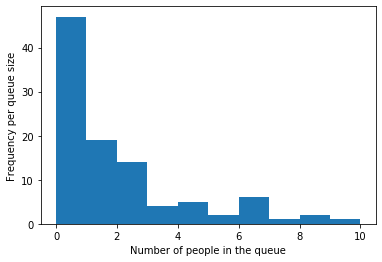

In [144]:
import matplotlib.pyplot as plt
#print(queue_overtime)
plt.hist(queue_overtime)
plt.xlabel("Number of people in the queue")
plt.ylabel("Frequency per queue size")
plt.show()

#### Compute an empirical estimate of the mean queue length (M/D/1) with arrival rate 0.8 and service rate 1, including a 95% confidence interval of the mean.

In [145]:
import scipy.stats as sts

mean_queue_100 = sum(queue_overtime)/len(queue_overtime)

print("The mean queue length is:", mean_queue_100)

# computing the standard error of the mean
t = sts.sem(queue_overtime)
print("Standard error of the mean:", t)

## formula for the confidence interval is [m + 1.96*t, m - 1.96*t]
## 1.96 is the z-score for a 95% confidence interval 
print("95% confidence interval of population mean:", [round(mean_queue_100 + 1.96*t, 4), round(mean_queue_100 - 1.96*t, 2)])

The mean queue length is: 1.5643564356435644
Standard error of the mean: 0.219547618409625
95% confidence interval of population mean: [1.9947, 1.13]


#### Computing a theoretical queue length value for M/D/1:

In [146]:
utilization_rate = 0.8/1
queue_length = (utilization_rate**2)/(2*(1-utilization_rate))
print(round(queue_length, 4))

1.6


## Second experiment: 1000 trials

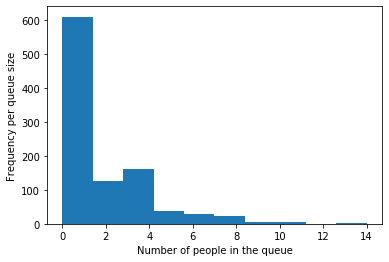

In [147]:
queue_overtime_1000 = []

for i in range(1001):
    bus_system = run_simulation(arrival_rate=0.8, service_rate=1, run_until=100)
    queue_overtime_1000.append(bus_system.queue.people_in_queue)
    
#print(queue_overtime)

plt.hist(queue_overtime_1000)
plt.xlabel("Number of people in the queue")
plt.ylabel("Frequency per queue size")
plt.show()

In [148]:
mean_queue_1000 = sum(queue_overtime_1000)/len(queue_overtime_1000)

print("The mean queue length is:", mean_queue_1000)

# computing the standard error of the mean
t = sts.sem(queue_overtime_1000)
print("Standard error of the mean:", t)

## formula for the confidence interval
## [m + 1.96*t, m - 1.96*t]
## 1.96 is the z-score for a 95% confidence interval 
print("95% confidence interval of population mean:", [round(mean_queue_1000 + 1.96*t, 4), round(mean_queue_1000 - 1.96*t, 2)])

The mean queue length is: 1.6413586413586414
Standard error of the mean: 0.0664216524661305
95% confidence interval of population mean: [1.7715, 1.51]


## Experiment comparison

**(1) Whether and how the distribution (histogram) over queue length changed.**

The distribution over queue length still follows the same pattern, though it got more right skewed, with queue length values from 4 and up getting less frequent.

**(2) Whether and how the average queue length estimate changed.**

In the experiment with a 1000 collections of the mean the confidence interval got narrower to [1.8115, 1.53] from [1.8318, 1.1]. Standard error of the sample mean decreased from 0.187 to 0.071 as we increased the sample size. The mean (average queue length) was computed the same way, though this time we value of the sample size increased from 100 to 1000, meaning we have collected more means. With a sample size getting bigger we mighht expect the curve getting narrower as the 95% of the same population we sample from 100 and 100 times, having more certainty with a narrower confidence interval.

**(3) Whether and how the confidence interval of the average queue length changed.**

The confidence interval changed, it got narrower to [1.8115, 1.53] from [1.8318, 1.1]. This happened as a result of the standard error of the mean decreasing from 0.187 to 0.071.

## Experiment with a modified arrival rate

In [149]:
# making 3 lists - for arrival rates, means, and errors 

arrival_rate_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
mean_list = []
error_list = []

In [150]:
## arrival_rate = 0.1
queue_overtime_1000 = []
for i in range(1001):
    bus_system = run_simulation(arrival_rate=0.1, service_rate=1, run_until=100)
    queue_overtime_1000.append(bus_system.queue.people_in_queue)
mean_queue_1000 = sum(queue_overtime_1000)/len(queue_overtime_1000)
t = sts.sem(queue_overtime_1000)

mean_list.append(mean_queue_1000)
error_list.append(2*1.96*t)

In [151]:
## arrival_rate = 0.2
queue_overtime_1000 = []
for i in range(1001):
    bus_system = run_simulation(arrival_rate=0.2, service_rate=1, run_until=100)
    queue_overtime_1000.append(bus_system.queue.people_in_queue)
mean_queue_1000 = sum(queue_overtime_1000)/len(queue_overtime_1000)
t = sts.sem(queue_overtime_1000)

mean_list.append(mean_queue_1000)
error_list.append(2*1.96*t)

In [152]:
## arrival_rate = 0.3
queue_overtime_1000 = []
for i in range(1001):
    bus_system = run_simulation(arrival_rate=0.3, service_rate=1, run_until=100)
    queue_overtime_1000.append(bus_system.queue.people_in_queue)
mean_queue_1000 = sum(queue_overtime_1000)/len(queue_overtime_1000)
t = sts.sem(queue_overtime_1000)

mean_list.append(mean_queue_1000)
error_list.append(2*1.96*t)

In [153]:
## arrival_rate = 0.4
queue_overtime_1000 = []
for i in range(1001):
    bus_system = run_simulation(arrival_rate=0.4, service_rate=1, run_until=100)
    queue_overtime_1000.append(bus_system.queue.people_in_queue)
mean_queue_1000 = sum(queue_overtime_1000)/len(queue_overtime_1000)
t = sts.sem(queue_overtime_1000)

mean_list.append(mean_queue_1000)
error_list.append(2*1.96*t)

In [154]:
## arrival_rate = 0.5
queue_overtime_1000 = []
for i in range(1001):
    bus_system = run_simulation(arrival_rate=0.5, service_rate=1, run_until=100)
    queue_overtime_1000.append(bus_system.queue.people_in_queue)
mean_queue_1000 = sum(queue_overtime_1000)/len(queue_overtime_1000)
t = sts.sem(queue_overtime_1000)

mean_list.append(mean_queue_1000)
error_list.append(2*1.96*t)

In [155]:
## arrival_rate = 0.6
queue_overtime_1000 = []
for i in range(1001):
    bus_system = run_simulation(arrival_rate=0.6, service_rate=1, run_until=100)
    queue_overtime_1000.append(bus_system.queue.people_in_queue)
mean_queue_1000 = sum(queue_overtime_1000)/len(queue_overtime_1000)
t = sts.sem(queue_overtime_1000)

mean_list.append(mean_queue_1000)
error_list.append(2*1.96*t)

In [156]:
## arrival_rate = 0.7
queue_overtime_1000 = []
for i in range(1001):
    bus_system = run_simulation(arrival_rate=0.7, service_rate=1, run_until=100)
    queue_overtime_1000.append(bus_system.queue.people_in_queue)
mean_queue_1000 = sum(queue_overtime_1000)/len(queue_overtime_1000)
t = sts.sem(queue_overtime_1000)

mean_list.append(mean_queue_1000)
error_list.append(2*1.96*t)

In [157]:
## arrival_rate = 0.8
queue_overtime_1000 = []
for i in range(1001):
    bus_system = run_simulation(arrival_rate=0.8, service_rate=1, run_until=100)
    queue_overtime_1000.append(bus_system.queue.people_in_queue)
mean_queue_1000 = sum(queue_overtime_1000)/len(queue_overtime_1000)
t = sts.sem(queue_overtime_1000)

mean_list.append(mean_queue_1000)
error_list.append(2*1.96*t)

In [158]:
## arrival_rate = 0.9
queue_overtime_1000 = []
for i in range(1001):
    bus_system = run_simulation(arrival_rate=0.9, service_rate=1, run_until=100)
    queue_overtime_1000.append(bus_system.queue.people_in_queue)
mean_queue_1000 = sum(queue_overtime_1000)/len(queue_overtime_1000)
t = sts.sem(queue_overtime_1000)

mean_list.append(mean_queue_1000)
error_list.append(2*1.96*t)

#### Error plot of the average queue length and it's 95% confidence interval for different values of the arrival rate. 

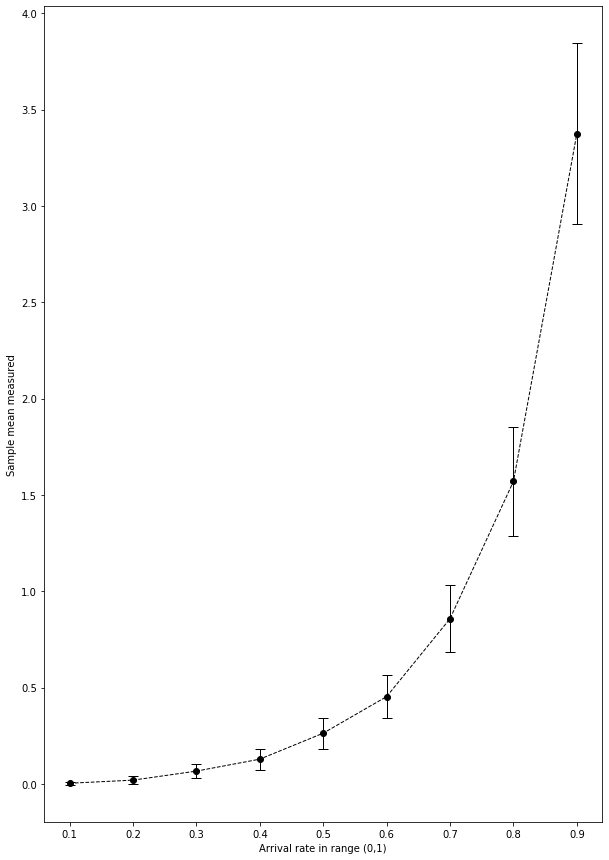

In [159]:
plt.figure(figsize=(10,15))

# making an error plot
plt.errorbar(arrival_rate_list, mean_list, error_list, color="black", marker="o", capsize = 5, linestyle = "--", linewidth=1)
plt.xlabel('Arrival rate in range (0,1)')
plt.ylabel('Sample mean measured')
plt.show()

#### Determine when the average queue length exceeds 5 people.

Based on the graph output I want to test how the average queue length behaves in range of [0.9, 1) values of the arrival rate. I will add the new values to the current list, and will make a plot setting a new limit of [0.9,1). Update: I have tried adding new values to the list and plotting them like above, but I have gotten errors with the function not being able to handle that many arguments. I am not sure how to fix this error, and I will fix it after the class.

## Reflection

I have visualized the results of simulations appropriately, modifying range, size of the figures, for it to be more readable. I have commented the lines of code to explain what I am doing; however, I have yet to improve to optimize the space in the notebook that code takes - I wanted to implement the function that would simply loop through all arrival rates in the list (from 0.1 to 0.9), however I had an error and decided to compute the error and mean values for each arrival separately, in a separate code block; I realize this is not a desired #professionalism level for code writing and I seek to improve. As for empirical analysis, I have used the correct formulas to analyze the simulations I made, and I compared simulations of 100 runs and 1000 runs based on their confidence intervals and standard errors.